In [3]:
import pickle
import numba
import numpy as np
from math import e
from os.path import basename, dirname, join as opj
from tqdm.notebook import tqdm
from umap import UMAP

from khan_helpers import Participant, Experiment

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/mnt/code/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.helpers import show_source<br />    show_source(foo)</pre>

In [4]:
exp = Experiment()

ff_traj, bos_traj = exp.load_lecture_trajs()
questions = exp.load_question_vectors()

In [5]:
# distance function
@numba.njit
def correlation_exp(x, y):
    x = e ** x
    y = e ** y
    mu_x = 0.0
    mu_y = 0.0
    norm_x = 0.0
    norm_y = 0.0
    dot_product = 0.0

    for i in range(x.shape[0]):
        mu_x += x[i]
        mu_y += y[i]

    mu_x /= x.shape[0]
    mu_y /= x.shape[0]

    for i in range(x.shape[0]):
        shifted_x = x[i] - mu_x
        shifted_y = y[i] - mu_y
        norm_x += shifted_x ** 2
        norm_y += shifted_y ** 2
        dot_product += shifted_x * shifted_y

    if norm_x == 0.0 and norm_y == 0.0:
        dist = 0.0
        grad = np.zeros(x.shape)
    elif dot_product == 0.0:
        dist = 1.0
        grad = np.zeros(x.shape)
    else:
        dist = 1.0 - (dot_product / np.sqrt(norm_x * norm_y))
        grad = ((x - mu_x) / norm_x - (y - mu_y) / dot_product) * dist

    return dist, grad

In [6]:
orders = {
    1: [ff_traj] + [bos_traj] + list(questions),
    2: [ff_traj] + list(questions) + [bos_traj],
    3: [bos_traj] + [ff_traj] + list(questions),
    4: [bos_traj] + list(questions) + [ff_traj],
    5: list(questions) + [ff_traj] + [bos_traj],
    6: list(questions) + [bos_traj] + [ff_traj]
}

In [7]:
ff_len = len(ff_traj)
bos_len = len(bos_traj)

In [9]:
COMBOS_RUN = []

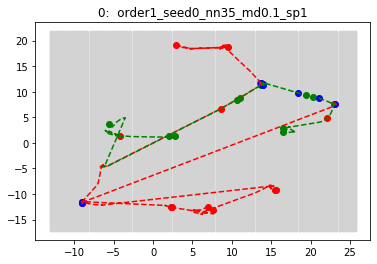

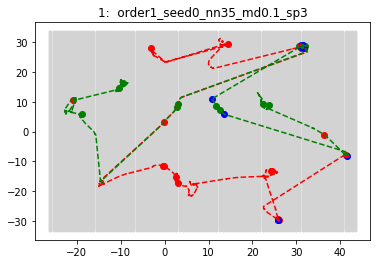

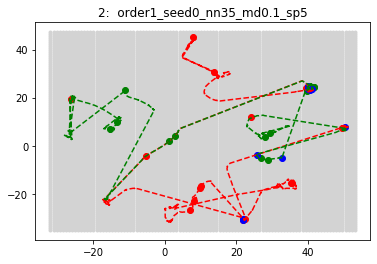

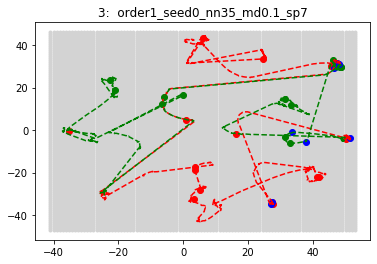

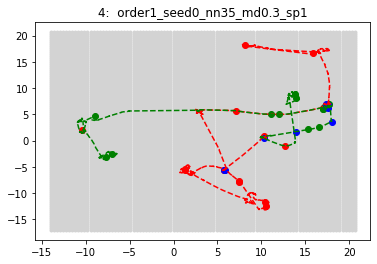

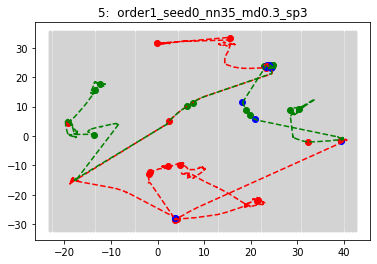

KeyboardInterrupt: 

In [10]:
for order, data in orders.items():
    split_inds = np.cumsum([np.atleast_2d(vec).shape[0] for vec in data])[:-1]
    to_reduce = np.log(np.vstack(data))
    
    for seed in range(10):
        for nn in [35]:
            for min_dist in (.1, .3, .5, .7):
                for spread in range(1, 8, 2):
                    run_key = f"order{order}_seed{seed}_nn{nn}_md{min_dist}_sp{spread}"
#                     if run_key in COMBOS_RUN:
#                         print(f"{run_key} ALREADY RUN")
#                         continue

                    params = {
                    'n_components': 2,
                    'init': 'spectral',
                    'metric': correlation_exp,
                    'random_state': seed,
                    'n_neighbors': nn,
                    'min_dist': min_dist,
                    'spread': spread
                    }
                    np.random.seed(seed)
                    reducer = UMAP(**params).fit(to_reduce)
                    embeddings = reducer.embedding_
                    embs_split = np.vsplit(embeddings, split_inds)
                    forces_emb = next(i for i in embs_split if len(i) == ff_len)
                    bos_emb = next(i for i in embs_split if len(i) == bos_len)
                    questions_embs = np.squeeze([i for i in embs_split if len(i) == 1])

                    resolution = 100
                    try:
                        x_min, y_min = embeddings.min(axis=0) // 1 - 3
                        x_max, y_max = embeddings.max(axis=0) // 1 + 3
                        xs = np.linspace(x_min, x_max, resolution, endpoint=False)
                        ys = np.linspace(y_min, y_max, resolution, endpoint=False)

                        X, Y = np.meshgrid(xs, ys)
                        xy_grid = np.empty((resolution, resolution, 2), dtype=np.float64)
                        for (x_ix, y_ix), X_val in np.ndenumerate(X):
                            xy_grid[x_ix, y_ix] = (X_val, Y[x_ix, y_ix])


                        vertices = xy_grid.reshape(resolution**2, 2)

                        plt.scatter(vertices[:, 0], vertices[:, 1], c='lightgrey', marker='.')
                        plt.plot(forces_emb[:, 0], forces_emb[:, 1], 'r--')
                        plt.plot(bos_emb[:, 0], bos_emb[:, 1], 'g--')
                        plt.scatter(questions_embs[:15, 0], questions_embs[:15, 1], c='r', marker='o')
                        plt.scatter(questions_embs[15:30, 0], questions_embs[15:30, 1], c='g', marker='o')
                        plt.scatter(questions_embs[30:, 0], questions_embs[30:, 1], c='b', marker='o')
                        plt.title(f"{len(COMBOS_RUN)}:  {run_key}")
                        # plt.plot(wordle_coords[:, 0], wordle_coords[:, 1], 'k*', markersize=8)
                        plt.show()
                        if run_key not in COMBOS_RUN:
                            COMBOS_RUN.append(run_key)

                    except Exception as e:
                        print(f"PROBLEM PLOTTING {run_key}: {type(e)}")
                        continue

            # save combos run every 25 to be safe
            np.save('COMBOS_RUN.npy', COMBOS_RUN)

In [17]:
data = orders[1]
split_inds = np.cumsum([np.atleast_2d(vec).shape[0] for vec in data])[:-1]
to_reduce = np.log(np.vstack(data))
seed = 0
nn = 20
md = 0.5
sp = 9
run_key = f"order{order}_seed{seed}_nn{nn}_md{min_dist}_sp{sp}"
params = {
'n_components': 2,
'init': 'spectral',
'metric': correlation_exp,
'random_state': seed,
'n_neighbors': nn,
'min_dist': md,
'spread': sp
}
np.random.seed(seed)
reducer = UMAP(**params).fit(to_reduce)
embeddings = reducer.embedding_
embs_split = np.vsplit(embeddings, split_inds)
forces_emb = next(i for i in embs_split if len(i) == ff_len)
bos_emb = next(i for i in embs_split if len(i) == bos_len)
questions_embs = np.squeeze([i for i in embs_split if len(i) == 1])

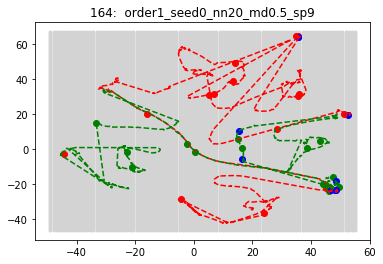

In [46]:
resolution = 100
x_min, y_min = embeddings.min(axis=0) // 1 - 3
x_max, y_max = embeddings.max(axis=0) // 1 + 3
xs = np.linspace(x_min, x_max, resolution, endpoint=False)
ys = np.linspace(y_min, y_max, resolution, endpoint=False)

X, Y = np.meshgrid(xs, ys)
xy_grid = np.empty((resolution, resolution, 2), dtype=np.float64)
for (x_ix, y_ix), X_val in np.ndenumerate(X):
    xy_grid[x_ix, y_ix] = (X_val, Y[x_ix, y_ix])


vertices = xy_grid.reshape(resolution**2, 2)

plt.scatter(vertices[:, 0], vertices[:, 1], c='lightgrey', marker='.')
plt.plot(forces_emb[:, 0], forces_emb[:, 1], 'r--')
plt.plot(bos_emb[:, 0], bos_emb[:, 1], 'g--')
plt.scatter(questions_embs[:15, 0], questions_embs[:15, 1], c='r', marker='o')
plt.scatter(questions_embs[15:30, 0], questions_embs[15:30, 1], c='g', marker='o')
plt.scatter(questions_embs[30:, 0], questions_embs[30:, 1], c='b', marker='o')
plt.title(f"{len(COMBOS_RUN)}:  {run_key}")
plt.show()

In [ ]:
fig, axarr = plt.subplots()

In [28]:
x_min, x_max, x_step

(-49.0, 56.0, 1.05)

In [29]:
y_min, y_max, y_step

(-46.0, 68.0, 1.14)

In [23]:
(x_max - x_min) / x_step

100.0

In [24]:
(y_max - y_min) / y_step

100.00000000000001

In [36]:
np.linspace(x_min, x_max, 100, endpoint=False)

array([-49.  , -47.95, -46.9 , -45.85, -44.8 , -43.75, -42.7 , -41.65,
       -40.6 , -39.55, -38.5 , -37.45, -36.4 , -35.35, -34.3 , -33.25,
       -32.2 , -31.15, -30.1 , -29.05, -28.  , -26.95, -25.9 , -24.85,
       -23.8 , -22.75, -21.7 , -20.65, -19.6 , -18.55, -17.5 , -16.45,
       -15.4 , -14.35, -13.3 , -12.25, -11.2 , -10.15,  -9.1 ,  -8.05,
        -7.  ,  -5.95,  -4.9 ,  -3.85,  -2.8 ,  -1.75,  -0.7 ,   0.35,
         1.4 ,   2.45,   3.5 ,   4.55,   5.6 ,   6.65,   7.7 ,   8.75,
         9.8 ,  10.85,  11.9 ,  12.95,  14.  ,  15.05,  16.1 ,  17.15,
        18.2 ,  19.25,  20.3 ,  21.35,  22.4 ,  23.45,  24.5 ,  25.55,
        26.6 ,  27.65,  28.7 ,  29.75,  30.8 ,  31.85,  32.9 ,  33.95,
        35.  ,  36.05,  37.1 ,  38.15,  39.2 ,  40.25,  41.3 ,  42.35,
        43.4 ,  44.45,  45.5 ,  46.55,  47.6 ,  48.65,  49.7 ,  50.75,
        51.8 ,  52.85,  53.9 ,  54.95])

In [42]:
ys

array([-46.  , -44.86, -43.72, -42.58, -41.44, -40.3 , -39.16, -38.02,
       -36.88, -35.74, -34.6 , -33.46, -32.32, -31.18, -30.04, -28.9 ,
       -27.76, -26.62, -25.48, -24.34, -23.2 , -22.06, -20.92, -19.78,
       -18.64, -17.5 , -16.36, -15.22, -14.08, -12.94, -11.8 , -10.66,
        -9.52,  -8.38,  -7.24,  -6.1 ,  -4.96,  -3.82,  -2.68,  -1.54,
        -0.4 ,   0.74,   1.88,   3.02,   4.16,   5.3 ,   6.44,   7.58,
         8.72,   9.86,  11.  ,  12.14,  13.28,  14.42,  15.56,  16.7 ,
        17.84,  18.98,  20.12,  21.26,  22.4 ,  23.54,  24.68,  25.82,
        26.96,  28.1 ,  29.24,  30.38,  31.52,  32.66,  33.8 ,  34.94,
        36.08,  37.22,  38.36,  39.5 ,  40.64,  41.78,  42.92,  44.06,
        45.2 ,  46.34,  47.48,  48.62,  49.76,  50.9 ,  52.04,  53.18,
        54.32,  55.46,  56.6 ,  57.74,  58.88,  60.02,  61.16,  62.3 ,
        63.44,  64.58,  65.72,  66.86,  68.  ])

In [45]:
np.linspace(y_min, y_max, 100, endpoint=False)

array([-46.  , -44.86, -43.72, -42.58, -41.44, -40.3 , -39.16, -38.02,
       -36.88, -35.74, -34.6 , -33.46, -32.32, -31.18, -30.04, -28.9 ,
       -27.76, -26.62, -25.48, -24.34, -23.2 , -22.06, -20.92, -19.78,
       -18.64, -17.5 , -16.36, -15.22, -14.08, -12.94, -11.8 , -10.66,
        -9.52,  -8.38,  -7.24,  -6.1 ,  -4.96,  -3.82,  -2.68,  -1.54,
        -0.4 ,   0.74,   1.88,   3.02,   4.16,   5.3 ,   6.44,   7.58,
         8.72,   9.86,  11.  ,  12.14,  13.28,  14.42,  15.56,  16.7 ,
        17.84,  18.98,  20.12,  21.26,  22.4 ,  23.54,  24.68,  25.82,
        26.96,  28.1 ,  29.24,  30.38,  31.52,  32.66,  33.8 ,  34.94,
        36.08,  37.22,  38.36,  39.5 ,  40.64,  41.78,  42.92,  44.06,
        45.2 ,  46.34,  47.48,  48.62,  49.76,  50.9 ,  52.04,  53.18,
        54.32,  55.46,  56.6 ,  57.74,  58.88,  60.02,  61.16,  62.3 ,
        63.44,  64.58,  65.72,  66.86])